In [8]:
# %pip install pycaret[full]
# %pip install ctgan

In [104]:
from pycaret.classification import *
from ctgan import CTGAN
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd

In [10]:
df = pd.read_csv("./creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [11]:
# Check if dataset has any NaN
df.isnull().any().any()

False

In [12]:
# Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [14]:
2 * 24 * 60 * 60 # 2 days of data in seconds

172800

In [15]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
# Test size of 8 hours, remaining for training
test_hours = 8
train_hours = 48 - test_hours
train_delta = train_hours * 60 * 60 # Convert to seconds
train_df = df[(df['Time'] >= 0) & (df['Time'] < train_delta)]
test_df = df[df['Time'] >= train_delta]

In [25]:
train_df['Class'].value_counts()

0    224450
1       415
Name: Class, dtype: int64

In [18]:
test_df['Class'].value_counts()

0    59865
1       77
Name: Class, dtype: int64

# Baseline Models

In [87]:
cc = setup(data=train_df, target='Class', session_id=42,
           train_size=0.8, # training over 80% of available data
           transformation=True, # transformation changes the shape of the distribution such that the transformed data can be represented by normal distribution
           normalize=True, # rescale the values of numeric columns
           remove_multicollinearity=True, # drop one of the two features that are highly correlated with each other
           normalize_method='robust',
           feature_selection=True)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(224865, 31)"
4,Transformed data shape,"(224865, 7)"
5,Transformed train set shape,"(179892, 7)"
6,Transformed test set shape,"(44973, 7)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [88]:
best_baseline_model = cc.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9990,0.9636,0.5656,0.8427,0.6715,0.6711,0.6871,0.8960
nb,Naive Bayes,0.9937,0.9636,0.8070,0.2369,0.3520,0.3501,0.4239,0.8840
ada,Ada Boost Classifier,0.9991,0.9614,0.6626,0.8215,0.7272,0.7268,0.7341,1.8900
qda,Quadratic Discriminant Analysis,0.9914,0.9605,0.8342,0.1939,0.2988,0.2966,0.3854,0.9060
catboost,CatBoost Classifier,0.9993,0.9600,0.7800,0.8536,0.8124,0.8120,0.8143,6.2520
et,Extra Trees Classifier,0.9994,0.9380,0.7590,0.9304,0.8322,0.8320,0.8381,1.4340
lda,Linear Discriminant Analysis,0.9989,0.9299,0.7436,0.7240,0.7248,0.7243,0.7288,0.9370
rf,Random Forest Classifier,0.9994,0.9292,0.7712,0.9137,0.8339,0.8336,0.8379,3.6650
knn,K Neighbors Classifier,0.9994,0.9125,0.7441,0.8949,0.8091,0.8088,0.8139,1.2810
dt,Decision Tree Classifier,0.9990,0.8731,0.7468,0.7119,0.7251,0.7246,0.7267,1.0470


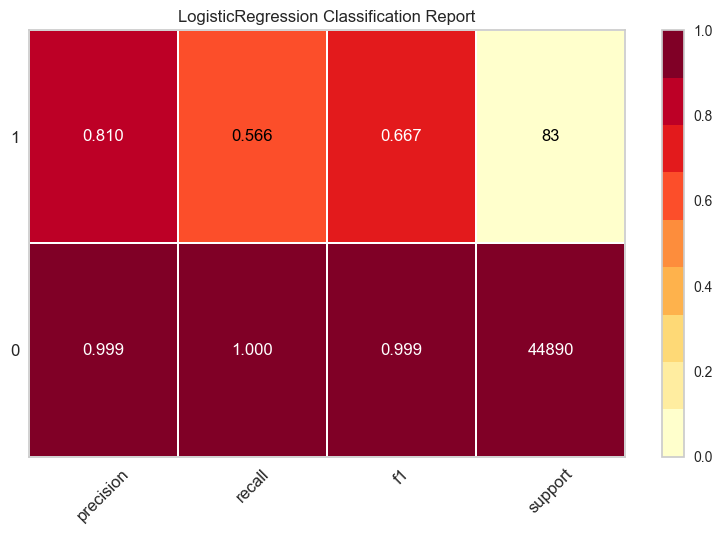

In [89]:
cc.plot_model(best_baseline_model, plot='class_report')

In [90]:
pred_df = cc.predict_model(best_baseline_model, data=test_df.copy().drop('Class', axis=1))

In [91]:
pred_df[pred_df['prediction_label'] == 1]['prediction_label'].count()

40

In [92]:
test_df[test_df['Class'] == 1]['Class'].count()

77

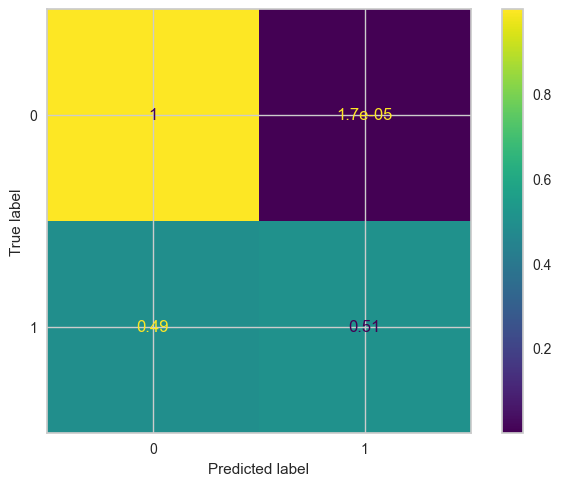

In [93]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_df['prediction_label'], normalize="true")

In [109]:
print(classification_report(test_df['Class'], pred_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.97      0.51      0.67        77

    accuracy                           1.00     59942
   macro avg       0.99      0.75      0.83     59942
weighted avg       1.00      1.00      1.00     59942



# CTGAN

In [47]:
discrete_columns = ['Class']
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(train_df, discrete_columns)

Gen. (-0.31) | Discrim. (-0.08): 100%|██████████| 300/300 [1:04:51<00:00, 12.97s/it]


In [48]:
ctgan.loss_values

,Epoch,Generator Loss,Discriminator Loss
0,0,tensor(-1.4020),tensor(-0.4583)
1,1,tensor(-2.8532),tensor(-0.0896)
2,2,tensor(-3.3054),tensor(0.0857)
3,3,tensor(-3.4455),tensor(0.0672)
4,4,tensor(-3.6664),tensor(0.0984)
...,...,...,...
295,295,tensor(-0.2031),tensor(-0.0918)
296,296,tensor(0.1725),tensor(-0.2323)
297,297,tensor(-0.0144),tensor(-0.0771)
298,298,tensor(-0.3330),tensor(-0.1452)


In [94]:
synthetic_train = ctgan.sample(train_df['Class'].value_counts()[0])#, condition_column='Class', condition_value=1)

In [95]:
synthetic_train['Class'].value_counts()

1    125422
0     99028
Name: Class, dtype: int64

In [96]:
gan_train_df = pd.concat([train_df, synthetic_train[synthetic_train['Class'] == 1]], ignore_index=True)
gan_train_df['Class'].value_counts()

0    224450
1    125837
Name: Class, dtype: int64

In [97]:
cc_gan = setup(data=gan_train_df, target='Class', session_id=42,
               train_size=0.8, # training over 80% of available data
               transformation=True, # transformation changes the shape of the distribution such that the transformed data can be represented by normal distribution
               normalize=True, # rescale the values of numeric columns
               remove_multicollinearity=True, # drop one of the two features that are highly correlated with each other
               normalize_method='robust',
               feature_selection=True)

[LightGBM] [Info] Number of positive: 100669, number of negative: 179560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 280229, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359238 -> initscore=-0.578672
[LightGBM] [Info] Start training from score -0.578672


,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(350287, 31)"
4,Transformed data shape,"(350287, 7)"
5,Transformed train set shape,"(280229, 7)"
6,Transformed test set shape,"(70058, 7)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [98]:
best_synthetic_model = cc_gan.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9571,0.9896,0.9122,0.9666,0.9386,0.9057,0.9066,10.6960
et,Extra Trees Classifier,0.9543,0.9895,0.8988,0.9720,0.9340,0.8992,0.9008,3.5210
rf,Random Forest Classifier,0.9548,0.9886,0.9068,0.9653,0.9351,0.9005,0.9015,8.2480
lightgbm,Light Gradient Boosting Machine,0.9473,0.9847,0.8897,0.9607,0.9238,0.8836,0.8852,2.0150
gbc,Gradient Boosting Classifier,0.9285,0.9725,0.8483,0.9472,0.8950,0.8411,0.8440,9.6470
knn,K Neighbors Classifier,0.9411,0.9662,0.8698,0.9628,0.9139,0.8694,0.8720,2.3720
ada,Ada Boost Classifier,0.9150,0.9646,0.8210,0.9345,0.8741,0.8103,0.8142,3.5940
qda,Quadratic Discriminant Analysis,0.8937,0.9455,0.7854,0.9062,0.8415,0.7622,0.7666,1.8030
nb,Naive Bayes,0.8893,0.9421,0.7685,0.9092,0.8329,0.7510,0.7569,1.5910
dt,Decision Tree Classifier,0.9289,0.9223,0.8989,0.9029,0.9009,0.8455,0.8455,1.9900


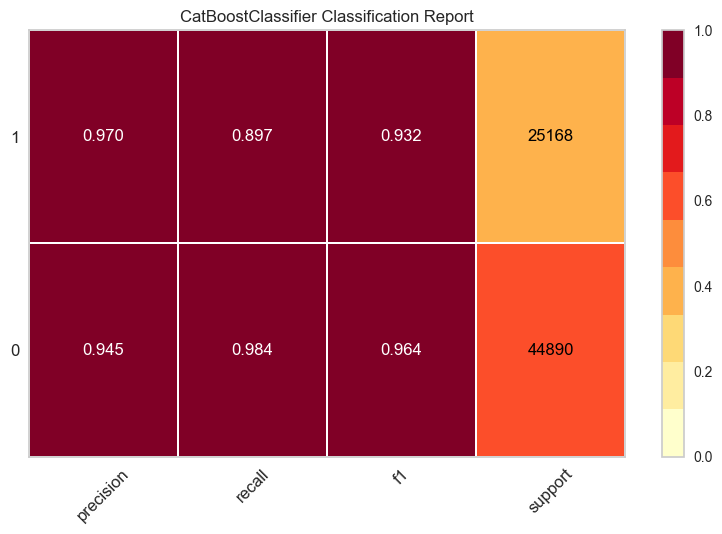

In [99]:
cc_gan.plot_model(best_synthetic_model, plot='class_report')

In [100]:
pred_gan_df = cc_gan.predict_model(best_synthetic_model, data=test_df.copy().drop('Class', axis=1))

In [101]:
pred_gan_df[pred_gan_df['prediction_label'] == 1]['prediction_label'].count()

1301

In [102]:
test_df[test_df['Class'] == 1]['Class'].count()

77

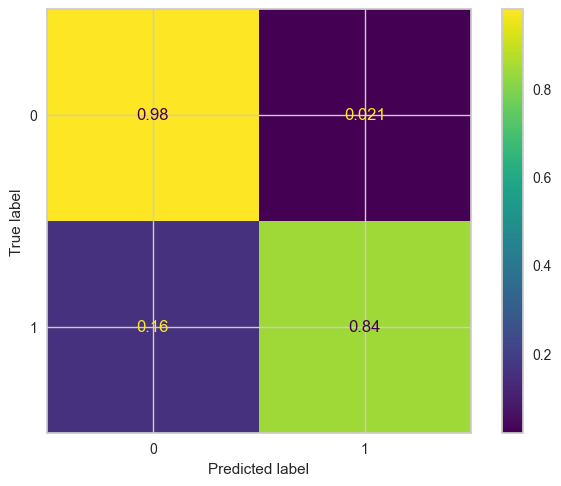

In [103]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_gan_df['prediction_label'], normalize="true")

In [110]:
print(classification_report(test_df['Class'], pred_gan_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59865
           1       0.05      0.84      0.09        77

    accuracy                           0.98     59942
   macro avg       0.52      0.91      0.54     59942
weighted avg       1.00      0.98      0.99     59942

